## Check for Programmatic variations


Matching Statistics for Hacky:
Number of matches in Hacky: 2658
Total Duplicates in Golden Standard: 938
Total Matched Duplicates: 497
Percentage Matched (%): 52.99

Precision: 0.1786
Recall: 0.5786

Matching Statistics for Sent_filtered2:
Number of matches in Sent_filtered2: 759
Total Duplicates in Golden Standard: 938
Total Matched Duplicates: 764
Percentage Matched (%): 81.45

Precision: 0.7975
Recall: 0.8189

Matching Statistics for TransE:
Number of matches in TransE: 758
Total Duplicates in Golden Standard: 938
Total Matched Duplicates: 768
Percentage Matched (%): 81.88

Precision: 0.8025
Recall: 0.8232

Matching Statistics for Distmult:
Number of matches in Distmult: 773
Total Duplicates in Golden Standard: 938
Total Matched Duplicates: 788
Percentage Matched (%): 84.01

Precision: 0.8082
Recall: 0.8419

Matching Statistics for Node2vec:
Number of matches in Node2vec: 737
Total Duplicates in Golden Standard: 938
Total Matched Duplicates: 793
Percentage Matched (%): 84.54

Precis

,Precision,Recall
Hacky,0.1786,0.5786
Sent_filtered2,0.7975,0.8189
TransE,0.8025,0.8232
Distmult,0.8082,0.8419
Node2vec,0.8436,0.8463
NetMf,0.8679,0.7549
DeepWalk,0.7993,0.7729


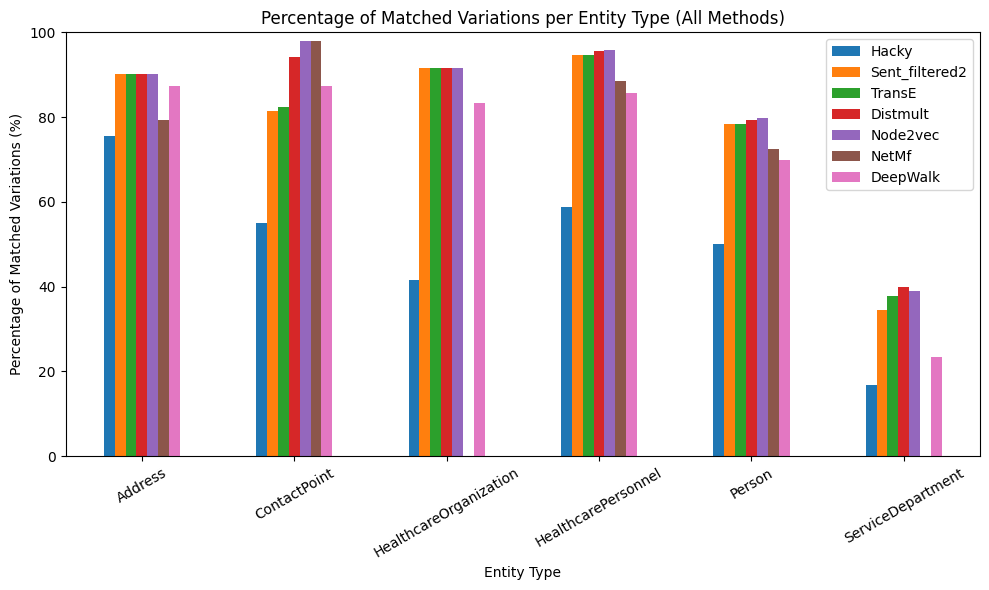

In [4]:
import pandas as pd
import json
import matplotlib.pyplot as plt

# Load the CSV and JSON files
golden_standard = pd.read_csv('data/prog_data/updated_golden_standard_duplicates2.csv')

# Load both match files
match_files = {
    'Hacky': json.load(open('matches/matchesHacky.json', 'r')),
    'Sent_filtered2': json.load(open('matches/SentenceEmbedding.json', 'r')),
    'TransE' : json.load(open('matches/HybridTransE_alpha_0.5.json', 'r')),
    'Distmult': json.load(open('matches/HybridDistmult_alpha_0.5.json', 'r')),
    'Node2vec': json.load(open('matches/HybridNode2vec_alpha_0.5.json', 'r')),
    'NetMf' : json.load(open('matches/HybridNetMf_alpha_0.5.json', 'r')),
    'DeepWalk' : json.load(open('matches/HybridDeepWalk_alpha_0.5.json', 'r')),
    


}

def extract_uuid(uri):
    return uri.split("/")[-1]
precision_recall_summary = {} 
percent_summary = {}
# Process each match file
for match_type, data in match_files.items():
    identifiers = []

    # Extract UUIDs directly from the subject URIs
    for match in data:
        pair = {}
        for entity_label in ['entity1', 'entity2']:
            entity = next(e[entity_label] for e in match['entities'] if entity_label in e)
            uri = entity.get("subject")
            pair[entity_label] = extract_uuid(uri) if uri else None
        identifiers.append(pair)

    # Check matches against the golden standard
    matched_rows = golden_standard[
        golden_standard.apply(
            lambda row: any(
                (pair['entity1'] == row['original_id'] and pair['entity2'] == row['duplicate_id']) 
                or (pair['entity1'] == row['duplicate_id'] and pair['entity2'] == row['original_id'])  # bi-directional match
                for pair in identifiers
            ),
            axis=1
        )
    ]

    # Overall matching statistics
    total = len(golden_standard)
    matched = len(matched_rows)
    pct_matched = matched / total * 100

    print(f"Matching Statistics for {match_type}:")
    print(f"Number of matches in {match_type}:", len(match_files[match_type]))
    print(f"Total Duplicates in Golden Standard: {total}")
    print(f"Total Matched Duplicates: {matched}")
    print(f"Percentage Matched (%): {pct_matched:.2f}\n")

    # Variation-type analysis
    gold_var = golden_standard['variation_type'].value_counts().rename('Golden Standard Count')
    match_var = matched_rows['variation_type'].value_counts().rename('Matched Count')

    variation_df = pd.concat([gold_var, match_var], axis=1).fillna(0).astype(int)
    variation_df['Matched (%)'] = variation_df['Matched Count'] / variation_df['Golden Standard Count'] * 100
    variation_df = variation_df.sort_index()

    

    # Entity-type analysis
    gold_ent = golden_standard['entity_type'].value_counts().rename('Golden Standard Count')
    match_ent = matched_rows['entity_type'].value_counts().rename('Matched Count')

    entity_df = pd.concat([gold_ent, match_ent], axis=1).fillna(0).astype(int)
    entity_df['Matched (%)'] = entity_df['Matched Count'] / entity_df['Golden Standard Count'] * 100
    entity_df = entity_df.sort_index()

    

    # Combined variation and entity-type analysis
    variation_entity_df = golden_standard.groupby(['variation_type', 'entity_type']).size().unstack(fill_value=0)
    matched_variation_entity_df = matched_rows.groupby(['variation_type', 'entity_type']).size().unstack(fill_value=0)

    frames = []
    for vtype in variation_entity_df.index:
        for etype in variation_entity_df.columns:
            golden_count = variation_entity_df.at[vtype, etype] if etype in variation_entity_df.columns else 0
            matched_count = matched_variation_entity_df.at[vtype, etype] if (vtype in matched_variation_entity_df.index and etype in matched_variation_entity_df.columns) else 0
            matched_pct = (matched_count / golden_count * 100) if golden_count > 0 else 0
            frames.append({
                'variation_type': vtype,
                'entity_type': etype,
                'Golden Standard Count': golden_count,
                'Matched Count': matched_count,
                'Matched (%)': matched_pct
            })
    # Calculate precision and recall
    # True Positives (TP): matched pairs that are in golden_standard
    TP = matched
    # False Positives (FP): matched pairs that are NOT in golden_standard
    matched_pairs_set = set(
        (pair['entity1'], pair['entity2']) if pair['entity1'] <= pair['entity2'] else (pair['entity2'], pair['entity1'])
        for pair in identifiers
    )
    golden_pairs_set = set(
        (row['original_id'], row['duplicate_id']) if row['original_id'] <= row['duplicate_id'] else (row['duplicate_id'], row['original_id'])
        for _, row in golden_standard.iterrows()
    )
    FP = len(matched_pairs_set - golden_pairs_set)
    # False Negatives (FN): golden_standard pairs not matched
    FN = len(golden_pairs_set - matched_pairs_set)

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    precision_recall_summary[match_type] = {'Precision': precision, 'Recall': recall}

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}\n")

    variation_entity_frame = pd.DataFrame(frames)
    variation_entity_frame = variation_entity_frame.sort_values(['variation_type', 'entity_type']).reset_index(drop=True)
    variation_frame = variation_entity_frame[variation_entity_frame['Golden Standard Count'] > 1]
    variation_frame = variation_frame.sort_values('entity_type').reset_index(drop=True)
    variation_frame

    matched_per_entity = variation_entity_frame.groupby('entity_type')['Matched Count'].sum()
    golden_per_entity = variation_entity_frame.groupby('entity_type')['Golden Standard Count'].sum()
    percent_matched = (matched_per_entity / golden_per_entity * 100).fillna(0)
    percent_summary[match_type] = percent_matched

pr_df = pd.DataFrame(precision_recall_summary).T  # Transpose for better display
pr_df = pr_df.round(4)
print("Precision and Recall per Method:")
display(pr_df)

percent_df = pd.DataFrame(percent_summary).fillna(0)
percent_df.plot(kind='bar', figsize=(10,6))
plt.xlabel('Entity Type')
plt.ylabel('Percentage of Matched Variations (%)')
plt.title('Percentage of Matched Variations per Entity Type (All Methods)')
plt.ylim(0, 100)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()




   

In [3]:
# Find all golden standard matches that were NOT found by the last algorithm run in the loop
missed_rows = golden_standard[~golden_standard.index.isin(matched_rows.index)]

print(f"Number of missed matches: {len(missed_rows)}")
missed_rows.head()  # Show a sample

Number of missed matches: 152


,original_id,duplicate_id,entity_type,variation_type,field_name,original_value,varied_value
4,603fa8f0-1549-4dee-830b-4d6d9575d095,bd4cf3d7-3c27-4645-99bd-a9a62e2d500a,Address,country_expansion,country,NL,Netherlands
14,5a8fe4b2-8ffd-4977-85b8-93b04d36c61a,bd4cf3d7-3c27-4645-99bd-a9a62e2d500a,Address,country_expansion,country,NL,Netherlands
20,929c8ac4-bf28-40fb-a8cb-2f6eee5e256e,bd4cf3d7-3c27-4645-99bd-a9a62e2d500a,Address,country_expansion,country,NL,Netherlands
32,f01688e4-b43b-4ab8-802b-7d666abb6f15,bd4cf3d7-3c27-4645-99bd-a9a62e2d500a,Address,country_expansion,country,NL,Netherlands
39,69259d81-2a2e-4ea7-9834-aeaf0f332bab,bd4cf3d7-3c27-4645-99bd-a9a62e2d500a,Address,country_expansion,country,NL,Netherlands


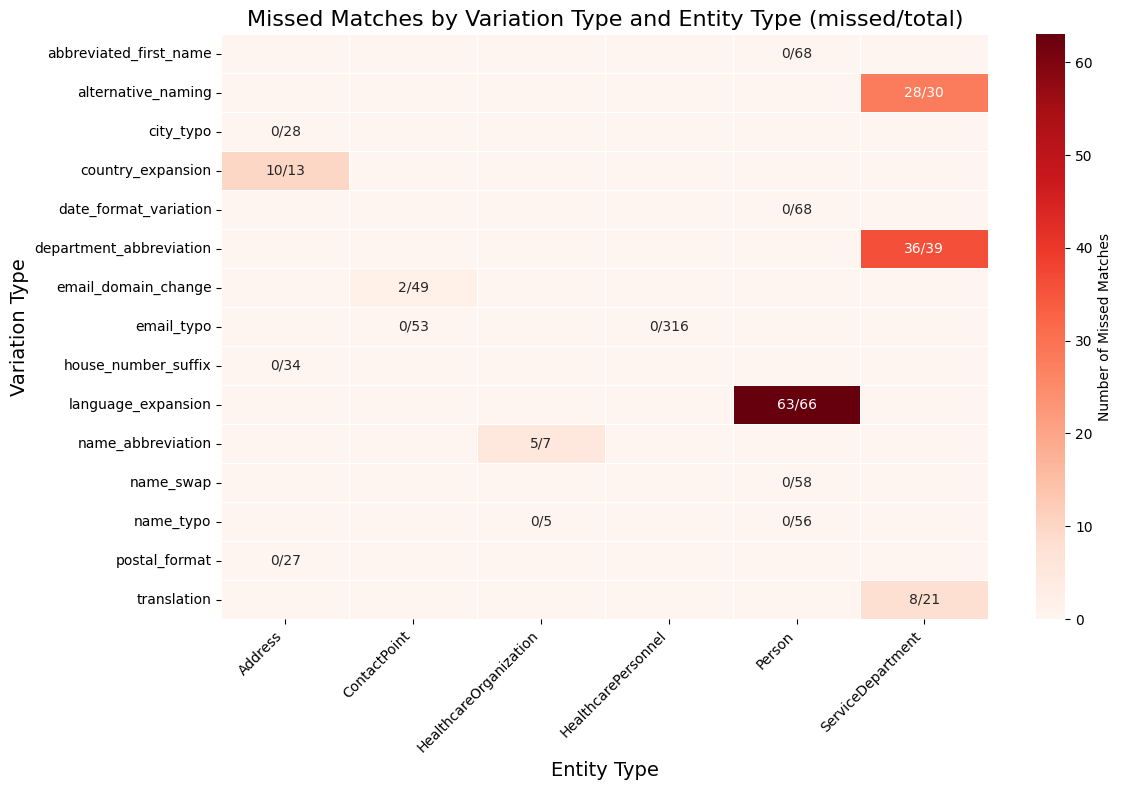

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Calculate missed and total counts
missed_counts = missed_rows.groupby(['variation_type', 'entity_type']).size().unstack(fill_value=0)
total_counts = golden_standard.groupby(['variation_type', 'entity_type']).size().unstack(fill_value=0)

# Ensure both have the same index and columns
all_index = total_counts.index.union(missed_counts.index)
all_columns = total_counts.columns.union(missed_counts.columns)
missed_counts = missed_counts.reindex(index=all_index, columns=all_columns, fill_value=0)
total_counts = total_counts.reindex(index=all_index, columns=all_columns, fill_value=0)

# Create annotation matrix like "missed/total"
annot = missed_counts.astype(str) + "/" + total_counts.astype(str)
# Replace "0/0" with empty string for clarity
annot = annot.where(total_counts != 0, "")

plt.figure(figsize=(12, 8))
sns.heatmap(
    missed_counts, 
    annot=annot, 
    fmt="", 
    cmap="Reds", 
    linewidths=.5, 
    cbar_kws={'label': 'Number of Missed Matches'}
)
plt.title("Missed Matches by Variation Type and Entity Type (missed/total)", fontsize=16)
plt.ylabel("Variation Type", fontsize=14)
plt.xlabel("Entity Type", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import json

# Load the CSV and JSON files
golden_standard = pd.read_csv('data/prog_data/updated_golden_standard_duplicates2.csv')

# Load both match files
match_files = {
    'Hacky': json.load(open('matches/matchesHacky.json', 'r')),
    'Distmult': json.load(open('matches/HybridDistmult_filtered.json', 'r')),
    'Sent_filtered2': json.load(open('matches/SentenceEmbedding.json', 'r')),
    'Node2vec': json.load(open('matches/HybridNode2vec_filtered.json', 'r')),
}

def extract_uuid(uri):
    return uri.split("/")[-1]

# Process each match file
for match_type, data in match_files.items():
    identifiers = []

    # Extract UUIDs directly from the subject URIs
    for match in data:
        pair = {}
        for entity_label in ['entity1', 'entity2']:
            entity = next(e[entity_label] for e in match['entities'] if entity_label in e)
            uri = entity.get("subject")
            pair[entity_label] = extract_uuid(uri) if uri else None
        identifiers.append(pair)

    # Check matches against the golden standard
    matched_rows = golden_standard[
        golden_standard.apply(
            lambda row: any(
                (pair['entity1'] == row['original_id'] and pair['entity2'] == row['duplicate_id']) 
                or (pair['entity1'] == row['duplicate_id'] and pair['entity2'] == row['original_id'])  # bi-directional match
                for pair in identifiers
            ),
            axis=1
        )
    ]

    # Overall matching statistics
    total = len(golden_standard)
    matched = len(matched_rows)
    pct_matched = matched / total * 100

    print(f"Matching Statistics for {match_type}:")
    print(f"Number of matches in {match_type}:", len(match_files[match_type]))
    print(f"Total Duplicates in Golden Standard: {total}")
    print(f"Total Matched Duplicates: {matched}")
    print(f"Percentage Matched (%): {pct_matched:.2f}\n")

    # Variation-type analysis
    gold_var = golden_standard['variation_type'].value_counts().rename('Golden Standard Count')
    match_var = matched_rows['variation_type'].value_counts().rename('Matched Count')

    variation_df = pd.concat([gold_var, match_var], axis=1).fillna(0).astype(int)
    variation_df['Matched (%)'] = variation_df['Matched Count'] / variation_df['Golden Standard Count'] * 100
    variation_df = variation_df.sort_index()

    

    # Entity-type analysis
    gold_ent = golden_standard['entity_type'].value_counts().rename('Golden Standard Count')
    match_ent = matched_rows['entity_type'].value_counts().rename('Matched Count')

    entity_df = pd.concat([gold_ent, match_ent], axis=1).fillna(0).astype(int)
    entity_df['Matched (%)'] = entity_df['Matched Count'] / entity_df['Golden Standard Count'] * 100
    entity_df = entity_df.sort_index()

    

    # Combined variation and entity-type analysis
    variation_entity_df = golden_standard.groupby(['variation_type', 'entity_type']).size().unstack(fill_value=0)
    matched_variation_entity_df = matched_rows.groupby(['variation_type', 'entity_type']).size().unstack(fill_value=0)

    frames = []
    for vtype in variation_entity_df.index:
        for etype in variation_entity_df.columns:
            golden_count = variation_entity_df.at[vtype, etype] if etype in variation_entity_df.columns else 0
            matched_count = matched_variation_entity_df.at[vtype, etype] if (vtype in matched_variation_entity_df.index and etype in matched_variation_entity_df.columns) else 0
            matched_pct = (matched_count / golden_count * 100) if golden_count > 0 else 0
            frames.append({
                'variation_type': vtype,
                'entity_type': etype,
                'Golden Standard Count': golden_count,
                'Matched Count': matched_count,
                'Matched (%)': matched_pct
            })

    variation_entity_frame = pd.DataFrame(frames)
    variation_entity_frame = variation_entity_frame.sort_values(['variation_type', 'entity_type']).reset_index(drop=True)
    variation_frame = variation_entity_frame[variation_entity_frame['Golden Standard Count'] > 1]
    variation_frame = variation_frame.sort_values('entity_type').reset_index(drop=True)
    variation_frame

 # Set pandas display options to use the full width of the notebook
    pd.set_option('display.width', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.expand_frame_repr', False)
    print(f"Combined Variation and Entity-Type Analysis for {match_type}:")
    print(variation_frame)
   

Matching Statistics for Hacky:
Number of matches in Hacky: 2658
Total Duplicates in Golden Standard: 938
Total Matched Duplicates: 497
Percentage Matched (%): 52.99

Matching Statistics for Sent_filtered2:
Number of matches in Sent_filtered2: 759
Total Duplicates in Golden Standard: 938
Total Matched Duplicates: 764
Percentage Matched (%): 81.45

Matching Statistics for TransE:
Number of matches in TransE: 0
Total Duplicates in Golden Standard: 938
Total Matched Duplicates: 0
Percentage Matched (%): 0.00

Matching Statistics for Distmult:
Number of matches in Distmult: 569
Total Duplicates in Golden Standard: 938
Total Matched Duplicates: 590
Percentage Matched (%): 62.90

Matching Statistics for Node2vec:
Number of matches in Node2vec: 354
Total Duplicates in Golden Standard: 938
Total Matched Duplicates: 271
Percentage Matched (%): 28.89

Matching Statistics for NetMf:
Number of matches in NetMf: 607
Total Duplicates in Golden Standard: 938
Total Matched Duplicates: 685
Percentage Ma

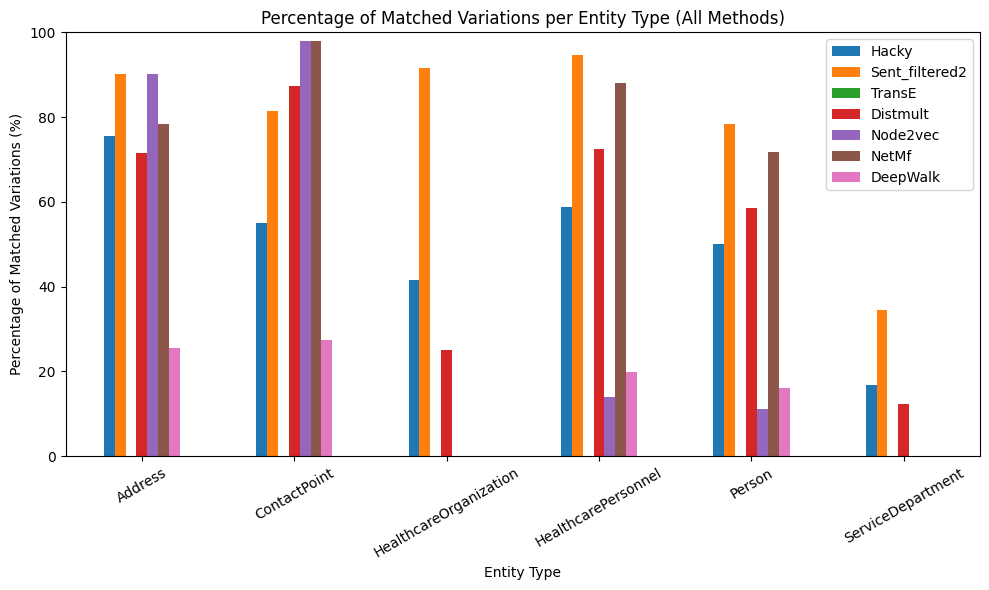

In [12]:
import pandas as pd
import json
import matplotlib.pyplot as plt

# Load the CSV and JSON files
golden_standard = pd.read_csv('data/prog_data/updated_golden_standard_duplicates2.csv')

# Load both match files
match_files = {
    'Hacky': json.load(open('matches/matchesHacky.json', 'r')),
    'Sent_filtered2': json.load(open('matches/SentenceEmbedding.json', 'r')),
    'TransE' : json.load(open('matches/HybridTransE_alpha_0.0.json', 'r')),
    'Distmult': json.load(open('matches/HybridDistmult_alpha_0.0.json', 'r')),
    'Node2vec': json.load(open('matches/HybridNode2vec_alpha_0.0.json', 'r')),
    'NetMf' : json.load(open('matches/HybridNetMf_alpha_0.0.json', 'r')),
    'DeepWalk' : json.load(open('matches/HybridDeepWalk_alpha_0.0.json', 'r')),
    


}

def extract_uuid(uri):
    return uri.split("/")[-1]
percent_summary = {}
# Process each match file
for match_type, data in match_files.items():
    identifiers = []

    # Extract UUIDs directly from the subject URIs
    for match in data:
        pair = {}
        for entity_label in ['entity1', 'entity2']:
            entity = next(e[entity_label] for e in match['entities'] if entity_label in e)
            uri = entity.get("subject")
            pair[entity_label] = extract_uuid(uri) if uri else None
        identifiers.append(pair)

    # Check matches against the golden standard
    matched_rows = golden_standard[
        golden_standard.apply(
            lambda row: any(
                (pair['entity1'] == row['original_id'] and pair['entity2'] == row['duplicate_id']) 
                or (pair['entity1'] == row['duplicate_id'] and pair['entity2'] == row['original_id'])  # bi-directional match
                for pair in identifiers
            ),
            axis=1
        )
    ]

    # Overall matching statistics
    total = len(golden_standard)
    matched = len(matched_rows)
    pct_matched = matched / total * 100

    print(f"Matching Statistics for {match_type}:")
    print(f"Number of matches in {match_type}:", len(match_files[match_type]))
    print(f"Total Duplicates in Golden Standard: {total}")
    print(f"Total Matched Duplicates: {matched}")
    print(f"Percentage Matched (%): {pct_matched:.2f}\n")

    # Variation-type analysis
    gold_var = golden_standard['variation_type'].value_counts().rename('Golden Standard Count')
    match_var = matched_rows['variation_type'].value_counts().rename('Matched Count')

    variation_df = pd.concat([gold_var, match_var], axis=1).fillna(0).astype(int)
    variation_df['Matched (%)'] = variation_df['Matched Count'] / variation_df['Golden Standard Count'] * 100
    variation_df = variation_df.sort_index()

    

    # Entity-type analysis
    gold_ent = golden_standard['entity_type'].value_counts().rename('Golden Standard Count')
    match_ent = matched_rows['entity_type'].value_counts().rename('Matched Count')

    entity_df = pd.concat([gold_ent, match_ent], axis=1).fillna(0).astype(int)
    entity_df['Matched (%)'] = entity_df['Matched Count'] / entity_df['Golden Standard Count'] * 100
    entity_df = entity_df.sort_index()

    

    # Combined variation and entity-type analysis
    variation_entity_df = golden_standard.groupby(['variation_type', 'entity_type']).size().unstack(fill_value=0)
    matched_variation_entity_df = matched_rows.groupby(['variation_type', 'entity_type']).size().unstack(fill_value=0)

    frames = []
    for vtype in variation_entity_df.index:
        for etype in variation_entity_df.columns:
            golden_count = variation_entity_df.at[vtype, etype] if etype in variation_entity_df.columns else 0
            matched_count = matched_variation_entity_df.at[vtype, etype] if (vtype in matched_variation_entity_df.index and etype in matched_variation_entity_df.columns) else 0
            matched_pct = (matched_count / golden_count * 100) if golden_count > 0 else 0
            frames.append({
                'variation_type': vtype,
                'entity_type': etype,
                'Golden Standard Count': golden_count,
                'Matched Count': matched_count,
                'Matched (%)': matched_pct
            })

    variation_entity_frame = pd.DataFrame(frames)
    variation_entity_frame = variation_entity_frame.sort_values(['variation_type', 'entity_type']).reset_index(drop=True)
    variation_frame = variation_entity_frame[variation_entity_frame['Golden Standard Count'] > 1]
    variation_frame = variation_frame.sort_values('entity_type').reset_index(drop=True)
    variation_frame

    matched_per_entity = variation_entity_frame.groupby('entity_type')['Matched Count'].sum()
    golden_per_entity = variation_entity_frame.groupby('entity_type')['Golden Standard Count'].sum()
    percent_matched = (matched_per_entity / golden_per_entity * 100).fillna(0)
    percent_summary[match_type] = percent_matched


percent_df = pd.DataFrame(percent_summary).fillna(0)
percent_df.plot(kind='bar', figsize=(10,6))
plt.xlabel('Entity Type')
plt.ylabel('Percentage of Matched Variations (%)')
plt.title('Percentage of Matched Variations per Entity Type (All Methods)')
plt.ylim(0, 100)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()




   